In [1]:
import torch
import torch.nn.functional as F
import torch.nn as nn
import torchvision
from torchvision import transforms
from torch.autograd import Variable

import os
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt

data_dir = "../data"

In [2]:
cuda = torch.device('cuda') 

In [3]:
example = torchvision.datasets.MNIST(data_dir, train=True, download=True, transform=transforms.ToTensor())
exampleloader = torch.utils.data.DataLoader(example, batch_size=4, shuffle=True, num_workers=2)
print(example.train_data.float().mean()/255)
example.train_data.float().std()/255

tensor(0.1307)


tensor(0.3081)

In [4]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

In [5]:
# Playing aroud to figure out how pytorch normalize works
arr = np.array([[[2, 2, 0], [1, 4, 1], [0, 3, 0]]], dtype=np.uint8)
meanval, stdval = np.mean(arr, axis=1), np.std(arr, axis=1)
print(arr, "mean={}, sd={}".format(meanval, stdval))
test = Image.fromarray(arr)
print("IMAGE", np.array(test))
test_tensor =transforms.ToTensor()(test)
print(test_tensor)
transforms.Normalize(meanval[0], stdval[0])(test_tensor)

[[[2 2 0]
  [1 4 1]
  [0 3 0]]] mean=[[1.         3.         0.33333333]], sd=[[0.81649658 0.81649658 0.47140452]]
IMAGE [[[2 2 0]
  [1 4 1]
  [0 3 0]]]
tensor(1.00000e-02 *
       [[[ 0.7843,  0.3922,  0.0000]],

        [[ 0.7843,  1.5686,  1.1765]],

        [[ 0.0000,  0.3922,  0.0000]]])


tensor([[[-1.2151, -1.2199, -1.2247]],

        [[-3.6646, -3.6550, -3.6598]],

        [[-0.7071, -0.6988, -0.7071]]])

In [6]:
BATCH_SIZE=64
EPOCHS=10
os.path.realpath(data_dir)
use_cuda = torch.cuda.is_available()
use_cuda

True

In [7]:
# Figure out the mean and sd of the dataset
trainset = torchvision.datasets.MNIST(data_dir, train=True, download=True, transform=transforms.ToTensor())
train_mean = trainset.train_data.float().mean()/255
train_sd = trainset.train_data.float().std()/255

# Define the transforms with proper normalizatin
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize([train_mean], [train_sd])])

# Load train and testsets
trainset = torchvision.datasets.MNIST(data_dir, train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, shuffle=True, batch_size=BATCH_SIZE, num_workers=4)

testset = torchvision.datasets.MNIST(data_dir, train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, shuffle=True, batch_size=BATCH_SIZE, num_workers=4)

In [8]:
"""Things to note
    each batch (iter) is a 4d tensor of (batchsize, channels, height, width)
    note that while image is is of form (H, W, Channels), tensors move the channel up a level
"""
for images, labels in trainloader:
    print(images.shape)
    print(labels.shape)
    print(labels)
    break

torch.Size([64, 1, 28, 28])
torch.Size([64])
tensor([ 4,  7,  7,  7,  1,  9,  0,  3,  7,  7,  7,  2,  8,  0,
         1,  3,  4,  3,  9,  9,  2,  7,  1,  6,  0,  2,  0,  0,
         8,  9,  5,  9,  5,  1,  3,  5,  0,  2,  1,  2,  3,  7,
         4,  4,  6,  8,  2,  0,  9,  8,  4,  7,  3,  7,  7,  4,
         8,  7,  6,  2,  8,  7,  7,  0])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Labels:  tensor([ 6,  6,  0,  2,  7,  8,  8,  3,  1,  1,  7,  2,  9,  4,
         8,  1,  2,  7,  4,  9,  4,  6,  9,  0,  2,  2,  8,  4,
         5,  3,  1,  8,  2,  2,  6,  8,  9,  2,  7,  2,  5,  6,
         6,  4,  1,  3,  7,  7,  7,  7,  6,  8,  8,  3,  8,  6,
         7,  1,  7,  5,  8,  1,  6,  7])
Batch shape:  torch.Size([64, 1, 28, 28])


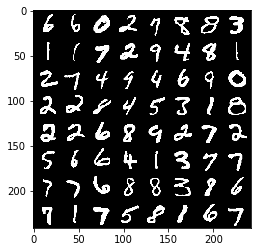

In [9]:
def show_batch(batch):
    im = torchvision.utils.make_grid(batch)
    plt.imshow(np.transpose(im.numpy(), (1, 2, 0)))
    
dataiter = iter(trainloader)
images, labels = dataiter.next()

print('Labels: ', labels)
print('Batch shape: ', images.size())
show_batch(images)

In [10]:
# Create the classifier
class ClassifierNet(nn.Module):
    def __init__(self):
        super().__init__()
        # From one feature, create 6 features to learn using a convolutional layer
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        # A good estimate of hidden node count is the feature count
        # Note: Image size decreases because of max pooling and convolutions
        # c1: 28 * 28 -> 24 * 24
        # pool1: 28 * 28 -> 12 * 12
        # c2: 12 * 12 -> 8 * 8
        # pool2: 8 * 8 -> 4 * 4
        # We have 4 * 4 <image size> * 16 <Learned features>
        self.fc1 = nn.Linear(16 * 4 * 4, 200)
        self.fc2 = nn.Linear(200, 100)
        # 10 final output nodes
        self.fc3 = nn.Linear(100, 10)
    
    def forward(self, x, afunc=F.relu):
        """
        @args
            afunc: Activation function to use.
        """
        x = self.pool(afunc(self.conv1(x)))
        x = self.pool(afunc(self.conv2(x)))
        x = x.view(-1, 16 * 4 * 4)
        x = afunc(self.fc1(x))
#         print(x.shape)
        x = afunc(self.fc2(x))
        x = self.fc3(x)
        return x

net = ClassifierNet()
if use_cuda:
    net = net.cuda()

In [11]:
# Adam performs well in general. Need to read more. Adaptive gradient variants do have their downsides too
from torch.optim import Adam
criterion = nn.CrossEntropyLoss()
optimizer = Adam(net.parameters())

In [12]:
# loss-records 
epoch_results = []
for epoch in range(EPOCHS):
    running_loss = 0.0
    for batch_id, data in enumerate(trainloader):
        inputs, labels = data
        if use_cuda:
            inputs, labels = inputs.cuda(), labels.cuda()
#         inputs, labels = Variable(inputs), Variable(labels)
        
#         print(inputs.shape, labels.shape)
        
        # Zero parameter gradients
        optimizer.zero_grad()
        
        # Generate outputs and calculate CEL
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        # Calculate backpropagation gradietns
        loss.backward()
        # Step the optimizer by a given epsilon
        optimizer.step()
        # Print the statistics
        running_loss += loss.item()
        if batch_id % 300 == 0:
            print("Epoch {}, batch {}, running_loss {:4f}".format(epoch, batch_id,
                                                                  running_loss / 1000))
            running_loss = 0.0
    # Test the trained NN
    total = 0
    correct = 0
    for batch_id, (inputs, labels) in enumerate(testloader):
        if use_cuda:
            inputs, labels = inputs.cuda(), labels.cuda()
            outputs = net(inputs)
            _, pred = torch.max(outputs, 1)
            total += inputs.data.size()[0]
            correct += (pred == labels).sum().item()
    epoch_results.append((epoch + 1, correct / total))

Epoch 0, batch 0, running_loss 0.002299
Epoch 0, batch 300, running_loss 0.136411
Epoch 0, batch 600, running_loss 0.037022
Epoch 0, batch 900, running_loss 0.026278
Epoch 1, batch 0, running_loss 0.000093
Epoch 1, batch 300, running_loss 0.020389
Epoch 1, batch 600, running_loss 0.018218
Epoch 1, batch 900, running_loss 0.018251
Epoch 2, batch 0, running_loss 0.000169
Epoch 2, batch 300, running_loss 0.013354
Epoch 2, batch 600, running_loss 0.013918
Epoch 2, batch 900, running_loss 0.012829
Epoch 3, batch 0, running_loss 0.000009
Epoch 3, batch 300, running_loss 0.010180
Epoch 3, batch 600, running_loss 0.011156
Epoch 3, batch 900, running_loss 0.011493
Epoch 4, batch 0, running_loss 0.000063
Epoch 4, batch 300, running_loss 0.008325
Epoch 4, batch 600, running_loss 0.009635
Epoch 4, batch 900, running_loss 0.007894
Epoch 5, batch 0, running_loss 0.000040
Epoch 5, batch 300, running_loss 0.007791
Epoch 5, batch 600, running_loss 0.006466
Epoch 5, batch 900, running_loss 0.009019
Epoc

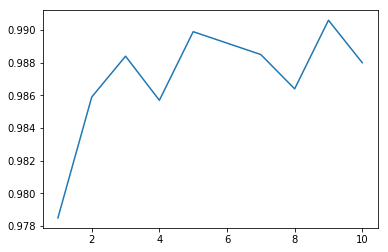

In [13]:
plt.plot(*zip(*epoch_results))
plt.show()

In [14]:
# class ModularNet(nn.Module):
#     def __init__(self, convs, ):
#         super().__init__()
#         # From one feature, create 6 features to learn using a convolutional layer
#         self.conv1 = nn.Conv2d(1, 6, 5)
#         self.pool = nn.MaxPool2d(2, 2)
#         self.conv2 = nn.Conv2d(6, 16, 5)
#         # A good estimate of hidden node count is the feature count
#         # Note: Image size decreases because of max pooling and convolutions
#         # c1: 28 * 28 -> 24 * 24
#         # pool1: 28 * 28 -> 12 * 12
#         # c2: 12 * 12 -> 8 * 8
#         # pool2: 8 * 8 -> 4 * 4
#         # We have 4 * 4 <image size> * 16 <Learned features>
#         self.fc1 = nn.Linear(16 * 4 * 4, 200)
#         self.fc2 = nn.Linear(200, 100)
#         # 10 final output nodes
#         self.fc3 = nn.Linear(100, 10)
    
#     def forward(self, x, afunc=F.relu):
#         """
#         @args
#             afunc: Activation function to use.
#         """
#         x = self.pool(afunc(self.conv1(x)))
#         x = self.pool(afunc(self.conv2(x)))
#         x = x.view(-1, 16 * 4 * 4)
#         x = afunc(self.fc1(x))
# #         print(x.shape)
#         x = afunc(self.fc2(x))
#         x = self.fc3(x)
#         return x

# def train_NN(ep)

SyntaxError: invalid syntax (<ipython-input-14-209493d567a0>, line 34)

In [16]:
# Test the trained NN
total = 0
correct = 0
for batch_id, (inputs, labels) in enumerate(testloader):
    if use_cuda:
        inputs, labels = inputs.cuda(), labels.cuda()
        outputs = net(inputs)
        _, pred = torch.max(outputs, 1)
        total += inputs.data.size()[0]
        correct += (pred == labels).sum().item()
print(f"Total samples: {total}. Total Correct: {correct}. Prop correct: {correct/total:.3f}")

Total samples: 10000. Total Correct: 9880. Prop correct: 0.988


torch.Size([64, 1, 28, 28])
torch.Size([1, 1, 28, 28])
tensor(9)


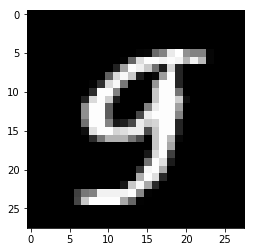

In [54]:
indata, ideal = iter(testloader).next()
print(indata.shape)
indata, ideal = indata[0].view(1, 1, 28, 28), ideal[0]
print(indata.shape)
showdata = indata[0][0].numpy() / 2  +0.5
plt.imshow(showdata, cmap="gray")
print(ideal)

In [75]:
print(net)

ClassifierNet(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=256, out_features=200, bias=True)
  (fc2): Linear(in_features=200, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=10, bias=True)
)


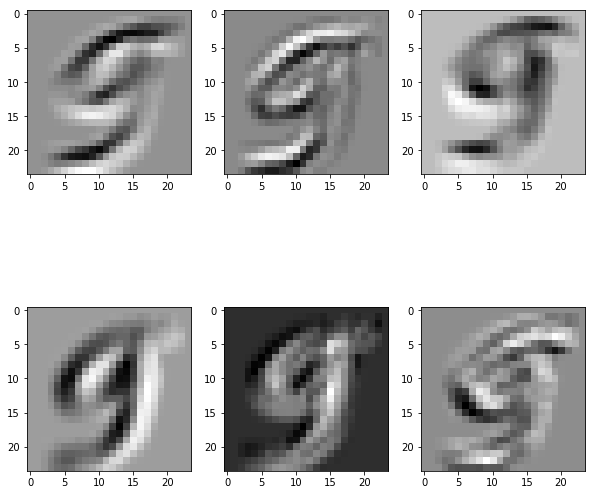

In [79]:
# Decompose
image = indata
h = net.conv1(indata.cuda())
plt.figure(1, figsize = (10, 10))
for num, i in enumerate(h[0]):
    showdata = i.cpu().detach().numpy() / 2  + 0.5
    plt.subplot(2, 3, num + 1)
    plt.imshow(showdata, cmap="gray")
    
h = net.pool(h)
h = net.conv2(h)

# plt.figure(1, figsize = (10, 10))
# for num, i in enumerate(h[0]):
#     showdata = i.cpu().detach().numpy() / 2  + 0.5
#     plt.subplot(2, 3, num + 1)
#     plt.imshow(showdata, cmap="gray")


In [77]:
h.shape

torch.Size([1, 16, 8, 8])

In [58]:
indatadata:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAADgAAACkCAYAAADCIu0mAAAABHNCSVQICAgIfAhkiAAAAAlwSFlzAAALEgAACxIB0t1+/AAAADl0RVh0U29mdHdhcmUAbWF0cGxvdGxpYiB2ZXJzaW9uIDIuMi4yLCBodHRwOi8vbWF0cGxvdGxpYi5vcmcvhp/UCwAAFulJREFUeJztnWtsXNe13397nmfOvIdDDt8PDSnKlCXoZUeKrIfhyDX0Ia6duIiDAG0S4H5JkdykUJq0gJsGKHJbBwH6oTAcIEVsoEDvRerAN4gAR3Hr4MoWbLlSFUkkJYrv5ww5T877tfthOCckJZFDUhpSAf/AgJzDOXvvxXPO3mv/9lp7hJSSv2bptrsBj1u7Bj7p2jXwSdeugWtJCPGSEOKOEOKeEOJHj6pRj1RSyk29AD0wDOwBTMANoG+z5T2u11au4LPAPSnliJQyB/xP4OUt/r8fubZiYAswuez91NKxHSXDFs4VDzh2n98nhPgb4G8ATCbTUZ/Pt3ahQqx45XI5SqWS9nedTkc0GiWRSDyo/vu0FQOngLZl71uBmdUfklL+EvglQHt7u7xw4cJ9BVksFlRVJZ1O8+677zI4OEgymaRYLOL1etHr9fj9fvbs2cPBgwf5xS9+UXUjt2LgVaBHCNEFTANfA76+0UIMBgOKojAyMsIHH3zA5cuX8fv9vPzyyzgcDjKZDCaTib6+PoxGI4VCYWPlb7RBFUkpC0KIfw18QLlH/e9SytsbKUMIgdls5tNPP+Wjjz5ienqan/3sZ7z44ovo9XomJ8uPuN/vx2AwEAgEGB4e3lA7t3IFkVJeBC5u5lwhBDabjWKxyOXLl8lkMnzta1/jm9/8JgDXrl3TDFyuYrG4oXq2ZOBmZTKZMBgMDA4OcuPGDQ4fPsyZM2fw+/1cu3aNsbExJiYmGBsbw+FwMDs7i8lkwul0briubTEwn88TCARYWFjA6XTS3d2NXq8nl8sxPz/PzMwMiUSCbDaLx+PBaDSiqipCiIqTUbW2xcB0Ok2pVMLr9VJXV4fFYsFoNJJIJLh+/Tqzs7PkcjkcDgculwur1YqqqqRSqQ3XtS0GWq1WrFYrpVKJVCpFJBLh2rVrXL9+na6uLg4dOoTH40FRFADsdjuFQmHDVw+2yUBFUdDpyk6UxWIhGAySy+Xo6enhtddew+12k81mCQaD2iC/0c6lom17Bj0eDzabDavVyqFDh8jn85jNZlRVJR6PMzs7SywWw+PxYDAYWFxc3FRd22ZgKpXCaDRit9u1ca7S+YTDYcbHxwmHwzQ2NqLX6zd1e0IVBgoh2oB3gUagBPxSSvlfhRAe4O+BTmAM+BdSykg1lUopicfjxONxJicnuX79OgBms5mpqSlGRkbIZrN0dnbicrlYWFjY9C1azWyiAPwbKeVTwHHgO0KIPuBHwIdSyh7gw6X3m5IQAlVVsVgs3Lp1i5mZGaxWK319fUgpyWazmy16/SsopZwFZpd+XxRCDFCeFr0MnF362DvAR8C/raZSi8WCXq9Hp9MhpSSRSBAMBhkaGmJycpJnnnmG06dP09nZydjY2Ib9z+Xa0DMohOgEDgOfAr4l45FSzgohGqotp1gskslkiEajTE1Ncf36dSYmJohGo3z3u9/l7NmztLa2UigUSKVSm37+YAMGCiFswP8C/lZKGReiqunYivmg2+0GYH5+nkwmg8FgoLOzky9+8Yu0tLTg9XqRUpJOpxkdHSUUCpFMJjds1HJVZaAQwkjZuP8hpXxv6XBACNG0dPWagOCDzl09HwTo7u6mrq6OpqYmGhsb8Xq9AIRCIW7evEkoFCIcDpPJZLZkHIBY7/KL8qV6BwhLKf922fE3gTrg5NLP21LKM+uUtQjc2UJ7vcAC0CGlrK/qjCro2XOUUcSfgf+39DoP1AMpYBT438At1qFqwOdbIWSbOb+aXvQyD+AvQogTwD9JKf/Z0vsfU+5Z+6v6z9ZIu1RtDW2KqrW2tq750EspKZVK2tBgNBoplUoIIWhra6OlpUVGo1GSyeTOo2qtra3ye9/73n0FxWIx8vk8TU1NvPjiizQ0lIdUk8nE7OysNgkeHx9Hr9c/WVStMh4eP36cs2fPEgwGee+995iamqJUKqHX64lEIszPz+N0OlmPq65WzaiaEOKllpaW5edTLBbJ5/N8+ctf5sCBA1y9epULFy7Q399PT08PLS0t6PV6RkdH6e7uxu/3E4vFKuVdogoHvyZUTQihB/7b8mPFYpFYLEZjYyOtra28/fbbvP322+RyOV5//XUOHTrEvXv3AHC5XLS1teHz+TQD+YuDv6b/W6v54LPAPcorUaRSKRRF4fz587hcLl555RXsdjuvvvoqdXV1hEIhBgcH8fl8uN1u7t69i9FoJBAILCdrVTn4tTJwxZDicDjw+/0kEgkuXbpEW1sbx44dI5PJEIlEKBaLKIpCa2srU1NTpNNpstksJpOJig9crYNfqxXeFV26y+UikUjw0UcfcePGDc6ePUs2m2Vubo6jR4+i1+tJp9NEIhF0Oh1CiB3PZFYMKWNjY8zPz6PX6zl58iQNDQ20trbyjW98gzfeeIN0Ok1rayvDw8O0tbVhtVoBWD6DWcvBX65aXcGrQE/lzeLiIpFIhHg8jqqqNDQ0kM1mef/997l58yYGg6G8OqvTkclkKBaLGAz3XYt/Cby/XsU1uYLLhpTfQ5mLptNp+vv7kVJy+/Ztbt68yZ07dzh9+jQej4fFxUUaGxtJpVKUSiWNkS7TOeC19equWZTF0pACgM1mo7m5GY/Hw+joKHfu3EEIwcGDBzl48CBQ9mJUVdX46eoJtpTyBSlleL16t4Wq6XQ6urq66OrqWnE8mUzS3d2tLZXZbDYymQyqqj7oFq1KO4KqlUolwuEwer2ehoYGpqamiEQi5HI5kskkqqputujtoWqLi4uaq1YoFFBVFZfLxYkTJ/j973/P9evXaW9vR1EUjEYjRqNxE6aVtS1UrYIN6+rq8Pl8uFwuDhw4QKlU4tvf/jYul4uDBw+SSqUwmUzac7gZ1ZSquVwuAG29IRgM8umnnzI5OcmtW7eYmpriJz/5CTabjXw+Tzab3dSi53LVlKpVJrsffvghk5OTJBIJIpEIbreblpYWTp48icfjIRKJUCqVtvTsaW3fpWq7VG2Xqm2rakrVFEU52tvbu+ZDXxkbK70olD0fo9FIR0cHe/fulYFAgFgstvOoWm9vr3zrrbfuKygYDGpxMWNjY9rYZzAY8Hq9KIpCIpHQplVPFFVLpVL8+c9/JhQKodfrOX36NNlslmw2SyKR4OjRo5hMJhRFQVEUUqnUfY73Wtr0MyilLAAVqjYA/MN6VG3V+eTzeaLRKJlMhoaGBjo6OnC73VgsFurr67VZfS6Xo6WlBafTqa1ECSEuCSHcj83ApUZelFLulVL6pZT/aQ3jHkjVZmdnGRsbw2q14vP5sFqt1NfXa9FN8/Pz9Pf3Mz09TalUWj0vrMrBr9V8sELVAEgkEoyPjzM5OUksFiOZTBIMBtHpdLjdbpxOp8Zjbt68ydTUFJ9//jnpdHr5gug7wD9fr+JaGbhiSLFYLDidTm1mHw6HyefzKIrC1NQUQ0NDBAIBFhcXtVAuYIXTveTor+vg1wo6regVnE4nZrOZWCxGqVRifHwcRVFYWFigUCgQj8dJJpMkEgk6OjqwWq3YbLZNVbwtVE1VVQ4dOsT+/ftpbGzk0qVLjI2NsW/fPs6dO0exWMRkMuHz+bDb7Roj3QxVq5WBK6haMpkkk8lQV1fHl770Jd566y1tBuFwOJifn6dYLGoRwTabDaPRuJqN7lyqlk6nmZubo1AoYDQaeeaZZzQ8kUgkyOfztLS0UCgUKBaLWmTwKlVF1WoWqyalvNjb2wuUGUwwGCSbzaKqKmazWRsGKpgwnU5TKBSw2Wx4PB50Ot2K9AIp5QvV1LstVA3QonuXKx6PMzo6SjKZJBAIkE6n2bNnDx6Ph1wuV23RK7RjqFogEGBkZAQhBF6vF6/Xi8fjobm5edPrErBNVC0QCBAKhZiZmWF6epqZmRmMRiM+n4/Tp09TKBRwuVzU19fjcrnI5/ObMK2sbaFq+Xyeqakp7t69y8DAAIFAgPr6elRV1a6Wx+PRYkU3e3tCjalaJbjg+PHjPP/88zgcDqSUhMNhcrkciURCm1UoiqIto21FVblqa1G1pb+vSdWklMeklMcq2DCTyZDNZrV4NCEEiqKgqip2ux2r1YpOp9uycbB1qhaSUv7dUvanR0r5w3XKeqKoWh1wHchRpmv/8XFQse2kanrAAeyj7GteFUL8vZTyr4aqPREprltx1R6EDb+w1gk2m+1oZ2fnpuOTOzo66OzslKFQiMXFxcdO1TaMDevq6njjjTfWLLTic1bGvnw+j6qq5HI5DR/+9Kc/rbqRNcWGD7t6lfFuYWGBYDBIoVBAr9cTjUbp6urC7XZrWTJms3lDjdzKM6hhQyGEiTI2/MeHfXg1VdMaoNMRCoUYHh5mcHCQWCxGsVjUBv7m5macTidut5u6ujptCe6xU7WNYMMHUbWl4xSLRQYHBxkaGiIWi2G326mrqwPKmTDt7e10dHRgs9mw2+3LodPjp2rVYkNWUTX4Szr5/Pw8o6OjxONxrFYrzz77LH19feTzeXQ6HQ6HA5/PhxCCRCJBPB6vFFEVVduWWDWdTkc8HufWrVtcuXKF/fv38/Wvf53Dhw/zhz/8gV//+tdcvnyZI0eO0NzcjMViYXh4mFAopBVYrYO/LbFqldzA27dvMzExwauvvsqZM2cwGo18/vnn9Pf3YzabURRFCx9xOp0bQvYV1crAFT1uKpVienqawcFBisUizz33HIqiaEFBuVwORVEwmUy4XC50Oh0mk2lFgTuaqlXItsPhoLGxkZGREW7cuMGVK1eYn5+nt7cXIQRPP/00DoeDeDxOKBTSAtWXtHOpmqIoeL1e4vE4NpuN6elpkskk2WyWw4cPA+UlNbkUgV9JqFylnRurZrFYaGlpob29HZ/Px9zcHJFIBJvNxqlTp7BYLIRCIYrFIqlUikQicd+sXu7kWDWLxUJTUxNCCPR6PcViUVsyKxQKDA4OEg6HsVgs5HI5UqnUk5UBWiFnTz/9NE899RQulwtFUSiVSrz77rt8/PHHdHR0cO7cOSKRCBMTEyuY6Ea0roFSylkp5bWl3xcpey0VqvbO0seqGnTXksFg0Lio1+vl0KFDPPXUU8Tj8S2hi22hapWNcIQQWieSyWSYmprCYDCwf/9+Tpw4gcfj4c6dO4+Xiy5r1JapWsXHzOVyWhZ2sVikVCqRSCQIBAL09PRw/vx5jhw5oq0drseN1lJNY9Uq06Xp6WmCwSDRaBQhBJ2dndTV1dHS0sIrr7yCXq9nZGSEQCCwJSZalYFLVO1XwICUcnn8xj9SHmz/jioH3YqklJqXYjabaWlp0Uh2PB4nGAwSiUS2RLS19leBDZ8D/gm4SXmYAPh3lJ/DPwL7Kfe0b0op/8M6Ze08bLgGwtvwxnFsAzbcpWpraMNUTa/XH1VVddNd4tL2ZDKXy1EoFHYeVTMajfT09Nx3UkWlUknb1iGXy2Gz2VBVlUwmQyaTQVEUotEoc3NzVTdyK7do1VRNLi2+PCz3IZVKaSmsPp+Pnp4eVFXVstScTidnzpyhp6dnRQZaNaoZVXuYcrkcwWB5CD127BhdXV2ar3rgwAGOHDmCz+cjm80Si8Xo6OjYUPnbFowH5Xi1cDiMw+HgK1/5CufOndMSlhsaGrhw4QJ79uyhsbGRfD6P0+nUdgaqFhtua4prJBIhFArxwx/+kIaGBmZmZmhrayOfz9Pd3Y1OpyMQCJDP50kmk5pLt6Sdm+Iaj8c1x/o73/kObrebiYkJFEXht7/9LQ6Hg3Q6re2nFgwG+eSTT2hoaFger1ZVXMC2BONVnOwvfOELdHd3lxui0zE5OUkoFKK3t5e+vj6cTifxeJxCoYDH40Gv12sFyiqD8bYFG0optdwkm82Gz+cjHA5z5coV/H4/fr+fdDpNJS29Eu20GW0LNty7dy9tbW04nU4GBgaYnZ1FURTa29vx+/3cu3cPs9nMCy+8oK1RLN/+AXZ4iqvBYMBut1NfX08ikcBoNNLc3MypU6dIJBLs3buXffv2EY/Htdi1ByCLqmYwNTFw2ZAClIPxKvFpDodDQ4JCCC34J5PJMDExQSAQeNimVecoT9XW1LoGCiHahBD/RwgxIIS4LYT43tJxz9JYNFTNmLQcGxYKBebm5ggGg8Tj8RW3X2UxJpvNEo1GCYfD2j9jVXmPBhvyF6p2TQhhB/7v0j4S/4oyVauEkaw7Ji1XKpViaGiIoaEh7VgkEsHhcHD+/HnsdjuXL1/WuOhmtSOoWmUAn5+f56WXXsLhcDA2Nqa5cDWBTvDoqFolZacCfo1GI+FwGKvVSm9vL2NjY0xPT+N2u7Uxc7NZoDWlapVc3EgkgsFgQFVVFEXB4XDQ3t7OiRMnGB0dZWFhgebmZrLZLIuLi48/xfVRUbXKZHfPnj1aakHFuMp6oJSSTCbDJ598cl/A7GMx8HFQNbfbjd1ux+Fw0NTURFNTE5lMhnQ6zcDAAGNjY0Sj0S1dOa39u1Rtl6rtUjVNqqoebWtr2zRVa21tpa2tTYbD4Zrsq7ZhquZ2u/n+97//8AKFwGg0oigKHo8HIQRzc3OMj48jpcRisVAoFHjnnXceWsZq1TRW7WFXz2q14nA4UFWVK1eukMlksNls1NfX09fXh91ux+fzYbFY6O/fWDjqtqe4mkwm6uvrSSaTfPzxx+j1ek6cOEFvby+qqpLNZtmzZw9dXV0a6tiIarpxXGtr6/L36HQ6zGYz8/PzjIyMsLCwwA9+8AOam5uZmZnhs88+43e/+x06nY59+/bR3t6u7TIrdvrGcTqdDpvNhk6no7+/n0KhwOnTp7l48SIDAwOkUimcTid6vZ6hoSEuXbqE3+/n9ddfrxSxc6mayWTCaDSSSqVIp9N4vV5isRifffYZBoMBv9+PXq9HCMHzzz9PLBbj5s2bqxO0di5VKxQKBAIBEomEthljJpOhubmZ7u5uYrEYV69e5U9/+hMulwuv16vFiVa0o6laLBZjcXERs9mM1Wolm83S0NCA3+9Hp9Npqa4Wi0XbZ7u1tXVTvum2pLjqdDrGx8f54x//iMvl4je/+Q2hUIiLFy8Sj8fp6uqira2N9vZ2gsEgyWSSfD6/YuK7o6mazWZDr9eTSCQYHBxkYGAAm83GyZMn6e7uJhKJsLCwoH01UeU7KVZp51I1o9FIZ2cnNpuNubk5rl69qmWgVbaDT6VSjIyM4PV6aW5ufhBZq4qq1SxWTUp5sa2tfJfm83k6Ozs5deoU+Xyen//857z33ntarJqUEqPRSCgUIhqNsrSiu7q8R5PiymOgalJKkskknZ2dfOtb39KOV+LV7ty5o60m2Ww2FhYWnuxYtcqgr6oq4+PjhEIhDAYDx44dw2AwbGlL+G2haqqqYrPZUBSFXC5HLpdjYWGB4eFhZmdn6erqoq6uDo/HQzqdrk2K66OgahU/soJJzGYzhUKBcDhMNBqlWCxy/PhxEokE4XAYo9GI0+l8cmLVKtOlu3fvYjabaW5upqOjg69+9au0t7cTCAR48803KZVKWjD6Zr5raUMGPg6qZjabGR0dZXBwEJ1Ox69+9SscDgelUgmPx0NHR4e2Q/pWtVWq9g9AOzABvLbeYsh2ULV1DXyUEkJ8LqU8Vsvzd7+H90lXrQ38Za3Pr+kzuB3avUUflcQGvjf7UcUFAJtffHmcCzVAE3Bk6Xc7cBfoA/4L8KOl4z8C/vO6ddfIwBPAB8ve/xj48QbOf5/yBPcO0LTsn3Dnca4ubUSb3ot0rRkMO5WqLWnd7nv1DGYzFW9LrBoPWahZrrVmMEt/33lUbQObCqw3g4FqZzC16GSWOoXzlHvDYeDfr/PZtfaw+RAYWvrpWa/eXU/mSdeugU+6dg180rVr4JOuv3oD/z+AqXTpgd/AyAAAAABJRU5ErkJggg==

tensor([[[[-0.4241, -0.4241, -0.4241, -0.4241, -0.4241, -0.4241, -0.4241,
           -0.4241, -0.4241, -0.4241, -0.4241, -0.4241, -0.4241, -0.4241,
           -0.4241, -0.4241, -0.4241, -0.4241, -0.4241, -0.4241, -0.4241,
           -0.4241, -0.4241, -0.4241, -0.4241, -0.4241, -0.4241, -0.4241],
          [-0.4241, -0.4241, -0.4241, -0.4241, -0.4241, -0.4241, -0.4241,
           -0.4241, -0.4241, -0.4241, -0.4241, -0.4241, -0.4241, -0.4241,
           -0.4241, -0.4241, -0.4241, -0.4241, -0.4241, -0.4241, -0.4241,
           -0.4241, -0.4241, -0.4241, -0.4241, -0.4241, -0.4241, -0.4241],
          [-0.4241, -0.4241, -0.4241, -0.4241, -0.4241, -0.4241, -0.4241,
           -0.4241, -0.4241, -0.4241, -0.4241, -0.4241, -0.4241, -0.4241,
           -0.4241, -0.4241, -0.4241, -0.4241, -0.4241, -0.4241, -0.4241,
           -0.4241, -0.4241, -0.4241, -0.4241, -0.4241, -0.4241, -0.4241],
          [-0.4241, -0.4241, -0.4241, -0.4241, -0.4241, -0.4241, -0.4241,
           -0.4241, -0.4241, -0.424

In [50]:
ideal

tensor(9)